In [1]:
# import autosklearn.classification
from pipeline import *

# pipeline_year(10)

df_coaches = pd.read_csv('dataset/cleaned/coaches.csv')
models = [
    lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    #lambda: LogisticRegression(max_iter=1000, random_state=42),
    lambda: SVC(C=1.0, kernel='rbf', probability=True),
    lambda: GaussianNB(),
    lambda: KNeighborsClassifier(n_neighbors=5),
    lambda: DecisionTreeClassifier(max_depth=5, random_state=42),
    lambda: GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    lambda: MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
]

def run_window_decay(model, year):
    l = []

    # param_grids = [
    #     {
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [5, 10, None],
    #         'min_samples_split': [2, 5, 10],
    #         'random_state': [42]
    #     },
    #     {
    #         'C': [1.0, 0.1, 0.01],
    #         'kernel': ['rbf', 'linear'],
    #         'probability': [True]
    #     },
    #     {},
    #     {
    #         'n_neighbors': [5, 10, 15],
    #         'weights': ['uniform', 'distance']
    #     },
    #     {
    #         'max_depth': [5, 10, 15],
    #         'min_samples_split': [2, 5, 10],
    #         'random_state': [42]
    #     },
    #     {
    #         'n_estimators': [100, 200, 300],
    #         'learning_rate': [0.1, 0.01, 0.001],
    #         'max_depth': [3, 5, 7],
    #         'random_state': [42]
    #     },
    #     {
    #         'hidden_layer_sizes': [(100, 50), (200, 100), (300, 150)],
    #         'max_iter': [1000, 2000, 3000],
    #         'random_state': [42]
    #     }
    #     ]

    clf = model()
    decay_rate=0.1
    df_teams_merged = []
    test = []
    train = []
    for i in range(2, year + 1):
        df_teams_merged = pipeline_clf(year=i)
        weight = decay_rate ** (10 - i - 1)

        df_teams_merged['confID'] = df_teams_merged['confID'].replace({'EA': 0, 'WE': 1})

        train = df_teams_merged[df_teams_merged['year'] < i]
        test = df_teams_merged[df_teams_merged['year'] == i]

        #if (year == i):
        #    break


        X_train = train[train.drop(['playoff', 'year', 'tmID'], axis=1).columns]
        y_train = train['playoff']
        sample_weight = [weight] * len(X_train)

        # grid_search_results = []
        # best_model = None
        # best_score = 0

        # # Perform grid search for each model
        # for model, param_grid in zip(models, param_grids):
        #     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        #     grid_search.fit(train.drop(['playoff', 'year', 'tmID'], axis=1), train['playoff'])  # Replace X and y with your data
        #     grid_search_results.append(grid_search)
        #     if grid_search.best_score_ > best_score:
        #         best_score = grid_search.best_score_
        #         best_model = grid_search.best_estimator_

        # for model, grid_search_result in zip(models, grid_search_results):
        #     print(f"Best parameters for {model.__class__.__name__}: {grid_search_result.best_params_}")
        #     print(f"Best score for {model.__class__.__name__}: {grid_search_result.best_score_}")

        # clf = best_model

        if type(model()).__name__ in ["KNeighborsClassifier", "MLPClassifier"]:
            clf.fit(X_train, y_train)  # This model don't support sample weights
        else:
            clf.fit(X_train, y_train, sample_weight=sample_weight)

    predictions = clf.predict_proba(test.drop(['playoff', 'year', 'tmID'], axis=1))[:, 1]
    test['predictions'] = predictions
    df_teams_merged['predictions'] = 0
    df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions

    df_teams_merged['confID'] = df_teams_merged['confID'].replace({0: 'EA', 1 : 'WE'})

    # print the year and the predicted scores
    # print(df_teams_merged[df_teams_merged['year'] == year][['tmID', 'confID', 'predictions', 'awards', 'offensive_strength']].sort_values(by='predictions', ascending=False))


    df_teams, ea_teams, we_teams = classify_playoff_entry(
            df_teams_merged, year)

    ea_predictions = ea_teams['tmID'].unique()
    we_predictions = we_teams['tmID'].unique()


    accuracy = calculate_playoff_accuracy(
        year, ea_predictions, we_predictions, display_results = False)

    return accuracy


here
    tmID  year  offensive_strength  defensive_strength confID  playoff   
2    ATL    11            0.091686            0.089444     EA      0.0  \
14   CHI    11            0.359402            0.447541     EA      0.0   
26   CON    11            0.869045            0.788144     EA      0.0   
56   IND    11            1.093206            1.203242     EA      0.0   
67   LAS    11            1.153442            1.322111     WE      0.0   
68   LAS    11            1.153442            1.322111     WE      0.0   
82   MIN    11            0.971590            0.993731     WE      0.0   
93   NYL    11            0.441216            0.290111     EA      0.0   
107  PHO    11            0.847105            0.749190     WE      0.0   
128  SAS    11            1.501856            1.511836     WE      0.0   
139  SEA    11            1.416331            1.103757     WE      0.0   
140  TUL    11            0.722337            0.566464     WE      0.0   
141  TUL    11            0.72233

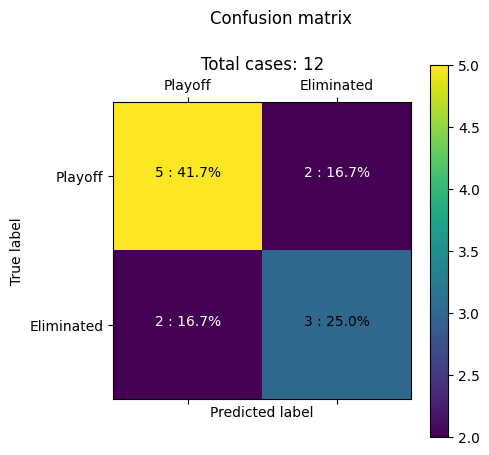

71.42857142857143

In [2]:
pipeline_year(11,display_results=True)

In [3]:
from pipeline import *

def check_accuracy_by_year2(models):
    # Create a list to store accuracy values for each model
    accs = []
    
    # Define the years
    years = list(range(2, 11))
    
    # Calculate accuracy for each year for each model
    for model in models:
        #model_accs = [run_window_decay(model, year) for year in years]
        model_accs = [pipeline_year(year, model=model, display_results=False) for year in years]
        accs.append(model_accs)
    #accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]
    print(accs)

    # Plot the accuracy line graphs for each model
    for i, model_acc in enumerate(accs):
        plt.plot(years, model_acc, label=f"{type(models[i]()).__name__ }", marker='o', linestyle='-', alpha=0.5)

    # Add labels for each data point
    # for i, model_acc in enumerate(accs):
    #     for j, acc in enumerate(model_acc):
    #         plt.text(years[j], acc, f"{acc:.2f}", ha="center", va="bottom")

    # Add legend
    plt.legend()

    # Set Y-axis limits
    plt.ylim(0, 100)

    plt.xlabel("Year")
    plt.ylabel("Precision")
    plt.title("Precision by year")
    plt.grid(True)

    plt.show()

check_accuracy_by_year2(models)


here
    tmID  year  offensive_strength  defensive_strength confID  playoff   
2    ATL    11            0.000000            0.000000      0      0.0  \
14   CHI    11            0.437924            0.286006      0      0.0   
26   CON    11           -0.426844           -0.174361      0      0.0   
56   IND    11            0.545064            1.646816      0      0.0   
67   LAS    11            1.324059            1.526085      0      0.0   
68   LAS    11            1.324059            1.526085      0      0.0   
82   MIN    11            1.208701            1.767377      0      0.0   
93   NYL    11            0.000000            0.000000      0      0.0   
107  PHO    11            0.000000            0.000000      0      0.0   
128  SAS    11            0.751309            0.496889      0      0.0   
139  SEA    11            2.558284            0.579150      0      0.0   
140  TUL    11            2.087990            1.742652      0      0.0   
141  TUL    11            2.08799

In [ ]:
run_window_decay(models[0], 10)

    tmID  year      Points  TotaloRebounds  TotaldRebounds  TotalAssists   
0    ATL     9         NaN             NaN             NaN           NaN  \
1    ATL    10         NaN             NaN             NaN           NaN   
2    ATL    11         NaN             NaN             NaN           NaN   
3    CHA     1  168.153846       23.461538       48.461538     42.384615   
4    CHA     2         NaN             NaN             NaN           NaN   
..   ...   ...         ...             ...             ...           ...   
149  WAS     7         NaN             NaN             NaN           NaN   
150  WAS     8         NaN             NaN             NaN           NaN   
151  WAS     9         NaN             NaN             NaN           NaN   
152  WAS    10         NaN             NaN             NaN           NaN   
153  WAS    11         NaN             NaN             NaN           NaN   

     TotalSteals  TotalBlocks  TotalTurnovers    TotalPF  TotalfgMade   
0            N

62.5

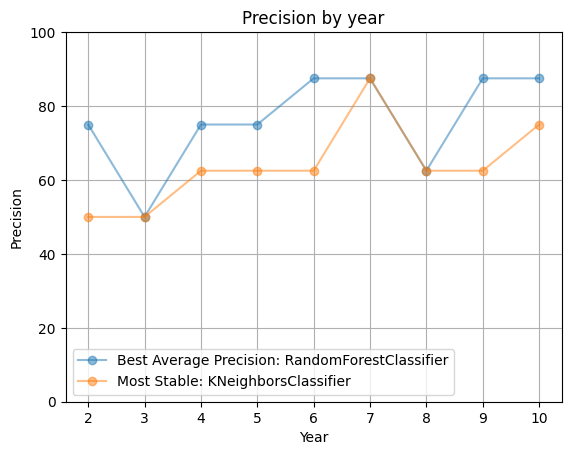

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]

years = list(range(2, 11))
model_names = [type(model()).__name__ for model in models]

# Calculate the average accuracy and standard deviation for each model
avg_accuracies = [np.mean(model_accs) for model_accs in accs]
std_accuracies = [np.std(model_accs) for model_accs in accs]

# Find the index of the model with the highest average accuracy and lowest standard deviation
best_avg_model_index = np.argmax(avg_accuracies)
most_stable_model_index = np.argmin(std_accuracies)

# Plot the accuracy line graphs for the best average model and the most stable model
plt.plot(years, accs[best_avg_model_index], label=f"Best Average Precision: {model_names[best_avg_model_index]}", marker='o', linestyle='-', alpha=0.5)
plt.plot(years, accs[most_stable_model_index], label=f"Most Stable: {model_names[most_stable_model_index]}", marker='o', linestyle='-', alpha=0.5)

# Add legend
plt.legend()

# Set Y-axis limits
plt.ylim(0, 100)

plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision by year")
plt.grid(True)

plt.show()